/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62971D+00    |proj g|=  3.73373D-02

At iterate    5    f=  1.62098D+00    |proj g|=  1.20031D-02

At iterate   10    f=  1.61606D+00    |proj g|=  1.51809D-02

At iterate   15    f=  1.61068D+00    |proj g|=  8.83864D-03

At iterate   20    f=  1.60632D+00    |proj g|=  6.81611D-03

At iterate   25    f=  1.60276D+00    |proj g|=  5.83057D-03

At iterate   30    f=  1.60128D+00    |proj g|=  1.45808D-02

At iterate   35    f=  1.60063D+00    |proj g|=  1.94507D-03

At iterate   40    f=  1.60054D+00    |proj g|=  4.37440D-04

At iterate   45    f=  1.60048D+00    |proj g|=  7.15136D-04

At iterate   50    f=  1.60031D+00    |proj g|=  1.24970D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/nf/j2h1gtcx0xq_f980r700bk380000gp/T/ipykernel_30334/2949049062.py:50: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  forecast = pd.DataFrame(index=pd.date_range(start=X.index[-1] + pd.Timedelta(minutes=10), periods=steps, freq='10T'))
/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, 

Model Performance for Next 144 Blocks:
MAE: 2.9381
RMSE: 3.5897
R²: -0.0462
MAPE: nan%
Directional Accuracy: 20.2797%
Theil's U Statistic: 0.6465


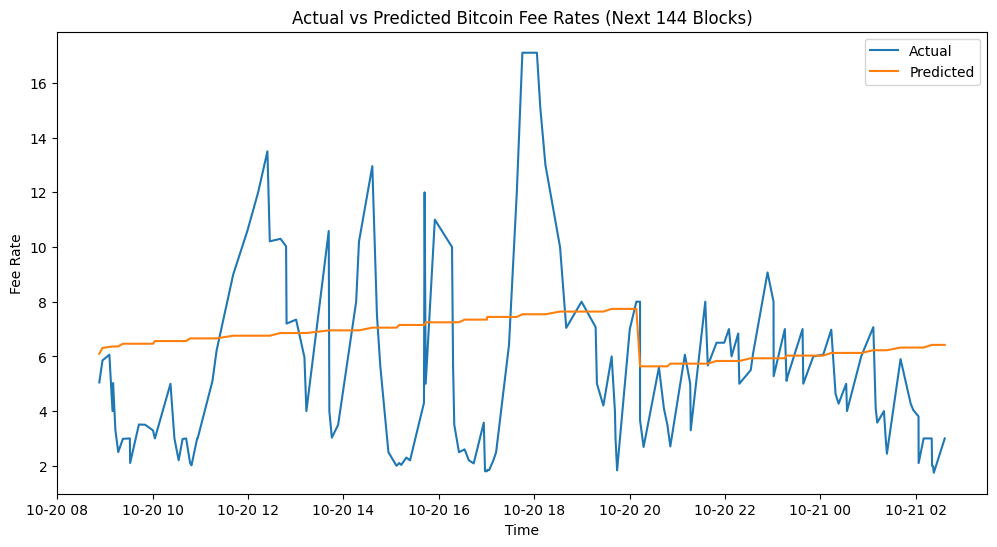

                                 SARIMAX Results                                 
Dep. Variable:     block_median_fee_rate   No. Observations:                 4901
Model:                  SARIMAX(1, 1, 1)   Log Likelihood               -7843.107
Date:                   Fri, 01 Nov 2024   AIC                          15728.214
Time:                           18:42:57   BIC                          15864.651
Sample:                                0   HQIC                         15776.082
                                  - 4901                                         
Covariance Type:                     opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
tx_count                3.1902      0.255     12.522      0.000       2.691       3.690
mempool_size_mb        17.4893      0.877     19.943      0.000      15.771     

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


df = pd.read_csv('real_time_cleaned.csv')
df['block_time'] = pd.to_datetime(df['block_time'])


df['hour'] = df['block_time'].dt.hour
df['day_of_week'] = df['block_time'].dt.dayofweek

df = df.sort_values('block_time').set_index('block_time')

features = [
    'tx_count', 'mempool_size_mb', 'avg_fee_rate',
    'fee_rate_10th', 'fee_rate_90th', 'fee_rate_std',
    'mempool_min_fee', 'total_fee', 'mempool_usage', 'transaction_count',
    'block_interval', 'bitcoin_price_usd',
    'hist_low_fee_ratio', 'hist_med_fee_ratio', 'hist_high_fee_ratio',
    'hist_fee_diversity', 'hour', 'day_of_week'
]
target = 'block_median_fee_rate'


X = df[features]
y = df[target]

# Handle infinite values
X = X.replace([np.inf, -np.inf], np.nan)

# Use RobustScaler
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X.fillna(X.median())), columns=X.columns, index=X.index)

# Split data_history into train and test (last 144 blocks for test)
train_X = X_scaled[:-144]
train_y = y[:-144]
test_y = y[-144:]

# Fit SARIMAX model
model = SARIMAX(train_y, exog=train_X, order=(1,1,1))
results = model.fit()

# Function to generate simple forecasts for exogenous variables
def forecast_exog(X, steps):
    forecast = pd.DataFrame(index=pd.date_range(start=X.index[-1] + pd.Timedelta(minutes=10), periods=steps, freq='10T'))
    for col in X.columns:
        if col in ['hour', 'day_of_week']:
            forecast[col] = forecast.index.hour if col == 'hour' else forecast.index.dayofweek
        else:
            # Use the last value for other variables
            forecast[col] = X[col].iloc[-1]
    return forecast

# Generate forecasts for exogenous variables
future_exog = forecast_exog(train_X, 144)

# Predict next 144 blocks
predictions = results.forecast(steps=144, exog=future_exog)

# Evaluation metrics
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def directional_accuracy(y_true, y_pred):
    return np.mean((np.diff(y_true) * np.diff(y_pred)) > 0) * 100


def theil_u(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate the percent changes
    y_true_pct = (y_true[1:] - y_true[:-1]) / y_true[:-1]
    y_pred_pct = (y_pred[1:] - y_true[:-1]) / y_true[:-1]  # Use y_true[:-1] as the base for both
    
    # Calculate Theil's U statistic
    numerator = np.sqrt(np.mean((y_true_pct - y_pred_pct)**2))
    denominator = np.sqrt(np.mean(y_true_pct**2)) + np.sqrt(np.mean(y_pred_pct**2))
    
    return numerator / denominator

mae = mean_absolute_error(test_y, predictions)
rmse = np.sqrt(mean_squared_error(test_y, predictions))
r2 = r2_score(test_y, predictions)
mape = mean_absolute_percentage_error(test_y, predictions)
da = directional_accuracy(test_y, predictions)
theils_u = theil_u(test_y, predictions)

print("Model Performance for Next 144 Blocks:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"Directional Accuracy: {da:.4f}%")
print(f"Theil's U Statistic: {theils_u:.4f}")

# Plot actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(test_y.index, test_y.values, label='Actual')
plt.plot(test_y.index, predictions, label='Predicted')
plt.title('Actual vs Predicted Bitcoin Fee Rates (Next 144 Blocks)')
plt.xlabel('Time')
plt.ylabel('Fee Rate')
plt.legend()
plt.show()


print(results.summary())

## Cross validation


Training fold 1/5


/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58145D+00    |proj g|=  3.58055D-02


 This problem is unconstrained.



At iterate    5    f=  1.57252D+00    |proj g|=  1.19731D-02

At iterate   10    f=  1.56876D+00    |proj g|=  1.20717D-02

At iterate   15    f=  1.56396D+00    |proj g|=  6.76654D-03

At iterate   20    f=  1.56002D+00    |proj g|=  1.36254D-02

At iterate   25    f=  1.55669D+00    |proj g|=  6.09163D-03

At iterate   30    f=  1.55572D+00    |proj g|=  5.07079D-03

At iterate   35    f=  1.55529D+00    |proj g|=  3.14019D-03

At iterate   40    f=  1.55520D+00    |proj g|=  2.18056D-03

At iterate   45    f=  1.55517D+00    |proj g|=  1.43968D-03


/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.55508D+00    |proj g|=  7.41395D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     53      1     0     0   7.414D-04   1.555D+00
  F =   1.5550776398126320     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/var/folders/nf/j2h1gtcx0xq_f980r700bk380000gp/T/ipykernel_30334/3938555905.py:49: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  forecast = pd.DataFrame(index=pd.date_range(start=X.index[-1] + pd.Timedelta(minutes=10),
/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


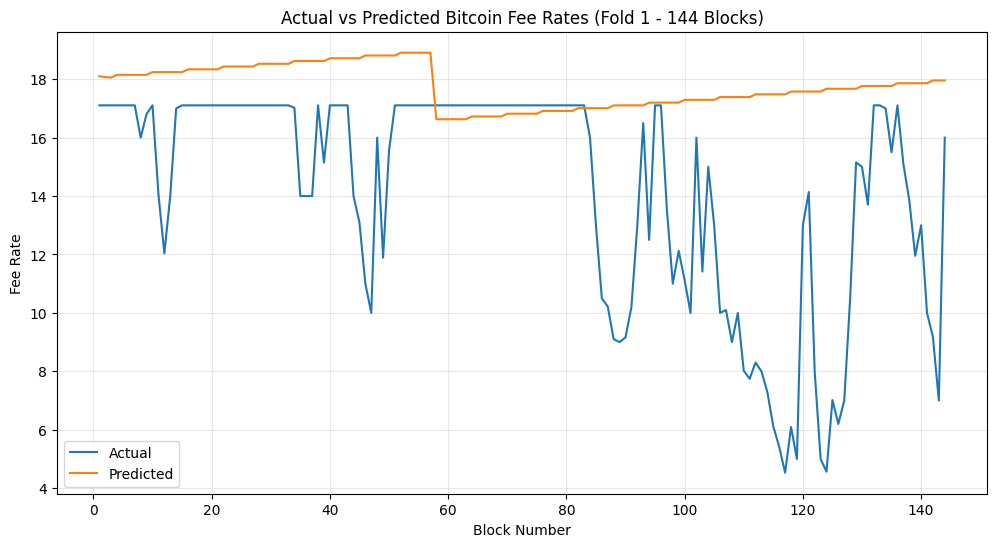


Fold 1 Metrics:
MAE: 3.6446
RMSE: 5.1274
R²: -0.8586
MAPE: 40.3261%
Directional Accuracy: 5.5944%
Theil's U: 0.7058

Training fold 2/5
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58390D+00    |proj g|=  3.51428D-02


/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.57519D+00    |proj g|=  1.18808D-02

At iterate   10    f=  1.57182D+00    |proj g|=  1.63291D-02

At iterate   15    f=  1.56772D+00    |proj g|=  1.06816D-02

At iterate   20    f=  1.56439D+00    |proj g|=  9.99301D-03

At iterate   25    f=  1.56119D+00    |proj g|=  4.45376D-03

At iterate   30    f=  1.56015D+00    |proj g|=  2.83685D-03

At iterate   35    f=  1.55974D+00    |proj g|=  1.65082D-03

At iterate   40    f=  1.55964D+00    |proj g|=  1.13111D-03

At iterate   45    f=  1.55959D+00    |proj g|=  4.87821D-03


/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.55951D+00    |proj g|=  2.84943D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     56      1     0     0   2.849D-03   1.560D+00
  F =   1.5595097031011291     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/var/folders/nf/j2h1gtcx0xq_f980r700bk380000gp/T/ipykernel_30334/3938555905.py:49: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  forecast = pd.DataFrame(index=pd.date_range(start=X.index[-1] + pd.Timedelta(minutes=10),
/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


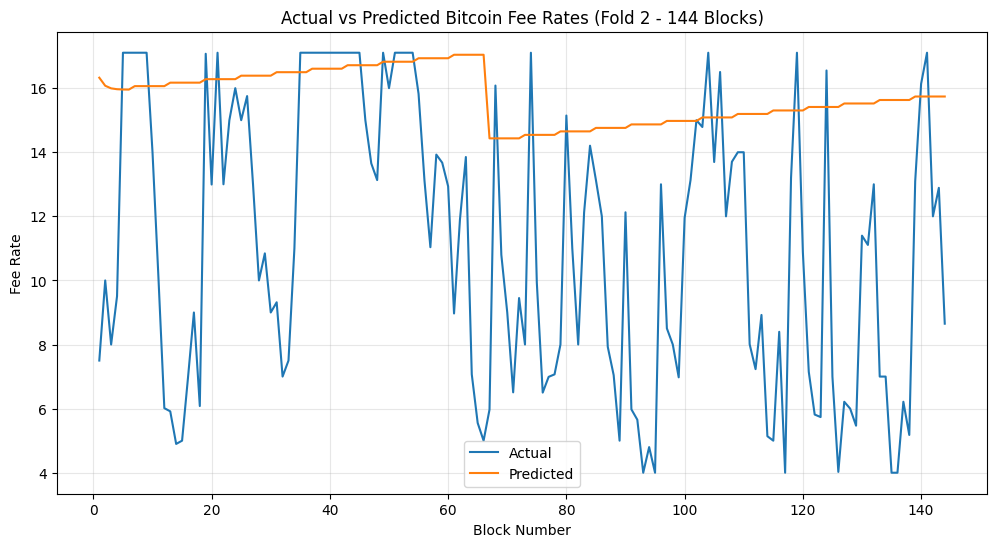


Fold 2 Metrics:
MAE: 4.9344
RMSE: 6.1733
R²: -1.0034
MAPE: 71.4295%
Directional Accuracy: 12.5874%
Theil's U: 0.5932

Training fold 3/5


/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.61456D+00    |proj g|=  3.75579D-02


 This problem is unconstrained.



At iterate    5    f=  1.60490D+00    |proj g|=  1.03706D-02

At iterate   10    f=  1.59985D+00    |proj g|=  9.67904D-03

At iterate   15    f=  1.59501D+00    |proj g|=  7.17733D-03

At iterate   20    f=  1.59128D+00    |proj g|=  9.87131D-03

At iterate   25    f=  1.58829D+00    |proj g|=  8.87885D-03

At iterate   30    f=  1.58724D+00    |proj g|=  2.04609D-03

At iterate   35    f=  1.58688D+00    |proj g|=  8.54072D-04

At iterate   40    f=  1.58682D+00    |proj g|=  7.27397D-04

At iterate   45    f=  1.58674D+00    |proj g|=  6.98552D-04


/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.58661D+00    |proj g|=  1.66706D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     57      1     0     0   1.667D-03   1.587D+00
  F =   1.5866081951519408     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/var/folders/nf/j2h1gtcx0xq_f980r700bk380000gp/T/ipykernel_30334/3938555905.py:49: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  forecast = pd.DataFrame(index=pd.date_range(start=X.index[-1] + pd.Timedelta(minutes=10),
/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


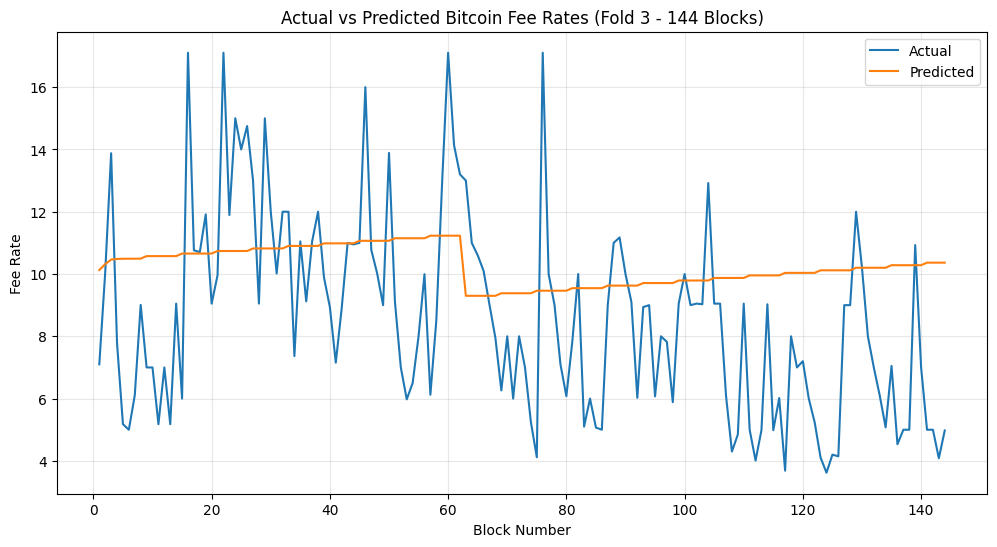


Fold 3 Metrics:
MAE: 2.8377
RMSE: 3.4353
R²: -0.1804
MAPE: 43.9985%
Directional Accuracy: 15.3846%
Theil's U: 0.5392

Training fold 4/5


/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62165D+00    |proj g|=  3.70280D-02

At iterate    5    f=  1.61250D+00    |proj g|=  1.13869D-02

At iterate   10    f=  1.60787D+00    |proj g|=  1.31183D-02

At iterate   15    f=  1.60212D+00    |proj g|=  6.34557D-03

At iterate   20    f=  1.59795D+00    |proj g|=  5.32799D-03

At iterate   25    f=  1.59526D+00    |proj g|=  4.09356D-03

At iterate   30    f=  1.59413D+00    |proj g|=  2.36813D-03

At iterate   35    f=  1.59367D+00    |proj g|=  1.87697D-03

At iterate   40    f=  1.59360D+00    |proj g|=  1.46377D-03

At iterate   45    f=  1.59353D+00    |proj g|=  7.85848D-04


/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.59343D+00    |proj g|=  1.07399D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     53      1     0     0   1.074D-03   1.593D+00
  F =   1.5934345782089123     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/var/folders/nf/j2h1gtcx0xq_f980r700bk380000gp/T/ipykernel_30334/3938555905.py:49: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  forecast = pd.DataFrame(index=pd.date_range(start=X.index[-1] + pd.Timedelta(minutes=10),
/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


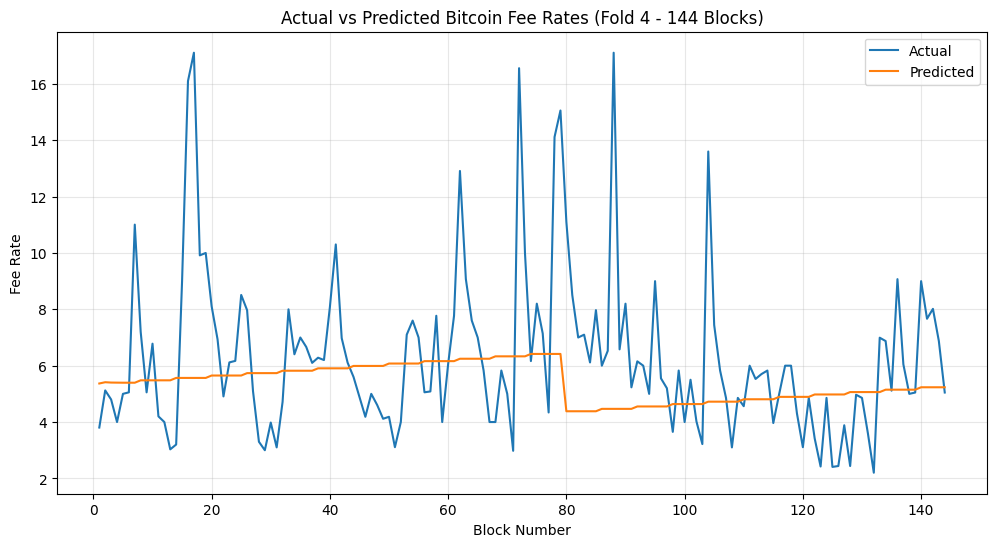


Fold 4 Metrics:
MAE: 2.0455
RMSE: 3.0253
R²: -0.0888
MAPE: 32.1347%
Directional Accuracy: 16.0839%
Theil's U: 0.5358

Training fold 5/5


/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62971D+00    |proj g|=  3.73373D-02


 This problem is unconstrained.



At iterate    5    f=  1.62098D+00    |proj g|=  1.20031D-02

At iterate   10    f=  1.61606D+00    |proj g|=  1.51809D-02

At iterate   15    f=  1.61068D+00    |proj g|=  8.83864D-03

At iterate   20    f=  1.60632D+00    |proj g|=  6.81611D-03

At iterate   25    f=  1.60276D+00    |proj g|=  5.83057D-03

At iterate   30    f=  1.60128D+00    |proj g|=  1.45808D-02

At iterate   35    f=  1.60063D+00    |proj g|=  1.94507D-03

At iterate   40    f=  1.60054D+00    |proj g|=  4.37440D-04

At iterate   45    f=  1.60048D+00    |proj g|=  7.15136D-04


/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.60031D+00    |proj g|=  1.24970D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     52      1     0     0   1.250D-03   1.600D+00
  F =   1.6003074826339707     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/var/folders/nf/j2h1gtcx0xq_f980r700bk380000gp/T/ipykernel_30334/3938555905.py:49: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  forecast = pd.DataFrame(index=pd.date_range(start=X.index[-1] + pd.Timedelta(minutes=10),
/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/jiangqinma/miniconda3/envs/bitcoin/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


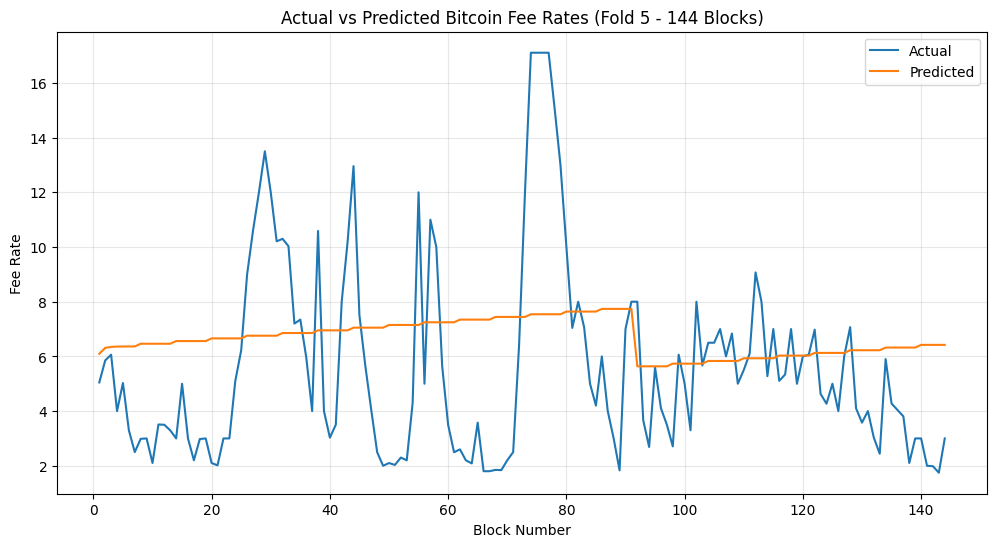


Fold 5 Metrics:
MAE: 2.9381
RMSE: 3.5897
R²: -0.0462
MAPE: 81.5631%
Directional Accuracy: 20.2797%
Theil's U: 0.6465

Cross-Validation Performance:
Mean Absolute Error (CV): 3.2801 (±0.9702)
Root Mean Squared Error (CV): 4.2702 (±1.1888)
R-squared Score (CV): -0.4355 (±0.4095)
MAPE (CV): 53.8904% (±19.1235%)
Theil's U Statistic (CV): 0.6041 (±0.0650)
Directional Accuracy (CV): 13.9860% (±4.8650%)
Training and Prediction time: 63.96s


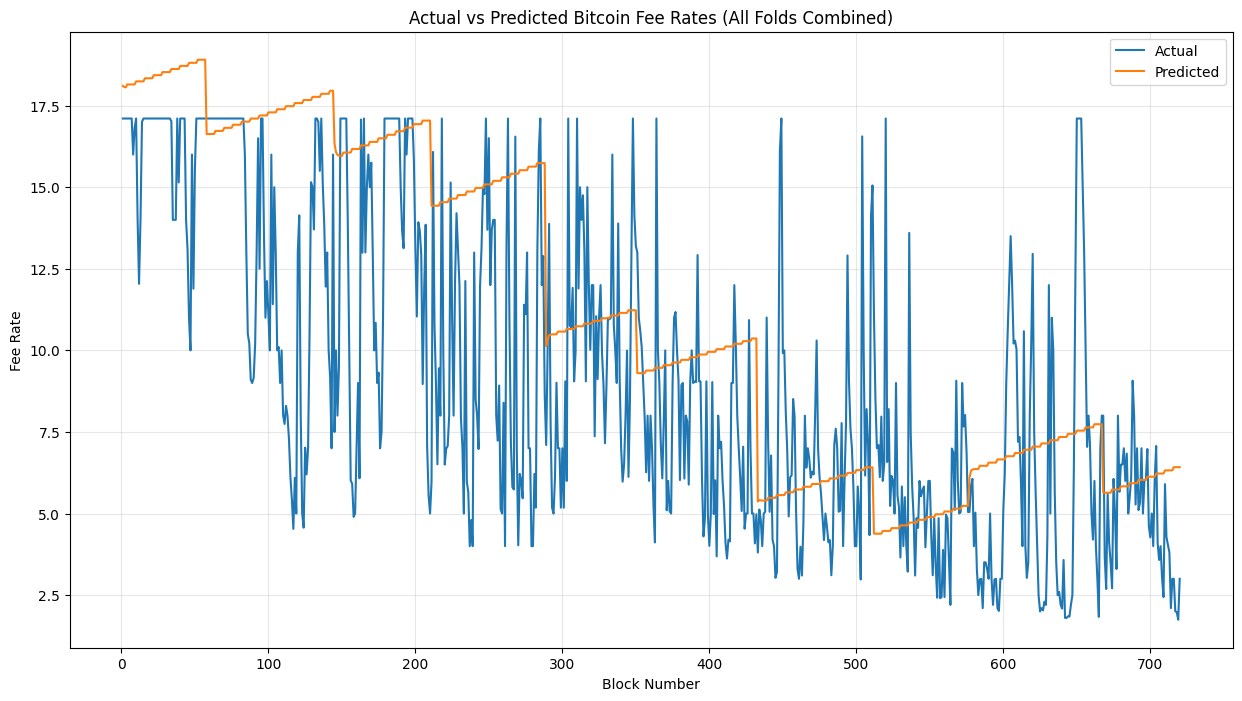


Detailed metrics for each fold:
   Fold       MAE      RMSE        R2       MAPE  DirectionalAccuracy  \
0     1  3.644601  5.127435 -0.858562  40.326140             5.594406   
1     2  4.934421  6.173261 -1.003388  71.429454            12.587413   
2     3  2.837698  3.435329 -0.180426  43.998457            15.384615   
3     4  2.045498  3.025311 -0.088786  32.134724            16.083916   
4     5  2.938116  3.589738 -0.046172  81.563069            20.279720   

    TheilsU  
0  0.705752  
1  0.593178  
2  0.539191  
3  0.535788  
4  0.646511  


In [6]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import time
import random

# Set a fixed seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)

# Call the function to set the seed
set_seed(42)
start = time.time()

# Load and preprocess data
df = pd.read_csv('real_time_cleaned.csv')
df['block_time'] = pd.to_datetime(df['block_time'])

df['hour'] = df['block_time'].dt.hour
df['day_of_week'] = df['block_time'].dt.dayofweek

df = df.sort_values('block_time').set_index('block_time')

features = [
    'tx_count', 'mempool_size_mb', 'avg_fee_rate',
    'fee_rate_10th', 'fee_rate_90th', 'fee_rate_std',
    'mempool_min_fee', 'total_fee', 'mempool_usage', 'transaction_count',
    'block_interval', 'bitcoin_price_usd',
    'hist_low_fee_ratio', 'hist_med_fee_ratio', 'hist_high_fee_ratio',
    'hist_fee_diversity', 'hour', 'day_of_week'
]
target = 'block_median_fee_rate'

X = df[features]
y = df[target]

# Handle infinite values
X = X.replace([np.inf, -np.inf], np.nan)

# Use RobustScaler
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X.fillna(X.median())), columns=X.columns, index=X.index)

def forecast_exog(X, steps):
    forecast = pd.DataFrame(index=pd.date_range(start=X.index[-1] + pd.Timedelta(minutes=10), 
                                              periods=steps, freq='10T'))
    for col in X.columns:
        if col in ['hour', 'day_of_week']:
            forecast[col] = forecast.index.hour if col == 'hour' else forecast.index.dayofweek
        else:
            forecast[col] = X[col].iloc[-1]
    return forecast

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def directional_accuracy(y_true, y_pred):
    return np.mean((np.diff(y_true) * np.diff(y_pred)) > 0) * 100

def theil_u(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    y_true_pct = (y_true[1:] - y_true[:-1]) / y_true[:-1]
    y_pred_pct = (y_pred[1:] - y_true[:-1]) / y_true[:-1]
    
    numerator = np.sqrt(np.mean((y_true_pct - y_pred_pct)**2))
    denominator = np.sqrt(np.mean(y_true_pct**2)) + np.sqrt(np.mean(y_pred_pct**2))
    
    return numerator / denominator

# Initialize lists to store cross-validation results
test_size = 144
n_splits = 5
n_total = len(X_scaled)

# Initialize lists to store metrics
mae_scores = []
rmse_scores = []
r2_scores = []
mape_scores = []
theil_u_scores = []
da_scores = []
all_y_true = []
all_y_pred = []

# Perform cross-validation
for fold_idx in range(n_splits):
    print(f"\nTraining fold {fold_idx+1}/{n_splits}")
    
    # Calculate indices
    train_end = n_total - (n_splits - fold_idx) * test_size
    test_start = train_end
    test_end = test_start + test_size
    
    # Create train and test sets
    train_X = X_scaled.iloc[:train_end]
    train_y = y.iloc[:train_end]
    test_y = y.iloc[test_start:test_end]
    
    # Fit SARIMAX model
    model = SARIMAX(train_y, exog=train_X, order=(1,1,1))
    results = model.fit()
    
    # Generate forecasts for exogenous variables
    future_exog = forecast_exog(train_X, test_size)
    
    # Generate predictions
    predictions = results.forecast(steps=test_size, exog=future_exog)
    
    # Store predictions and actual values
    y_true = test_y.values[:test_size]
    y_pred = predictions.values[:test_size]
    
    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)
    
    # Plot results for current fold
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(y_true) + 1), y_true, label='Actual')
    plt.plot(range(1, len(y_pred) + 1), y_pred, label='Predicted')
    plt.title(f'Actual vs Predicted Bitcoin Fee Rates (Fold {fold_idx + 1} - 144 Blocks)')
    plt.xlabel('Block Number')
    plt.ylabel('Fee Rate')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    da = directional_accuracy(y_true, y_pred)
    theils_u = theil_u(y_true, y_pred)
    
    # Store metrics
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mape_scores.append(mape)
    da_scores.append(da)
    theil_u_scores.append(theils_u)
    
    # Print metrics for current fold
    print(f"\nFold {fold_idx + 1} Metrics:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.4f}%")
    print(f"Directional Accuracy: {da:.4f}%")
    print(f"Theil's U: {theils_u:.4f}")

end = time.time()

# Print cross-validation results
print("\nCross-Validation Performance:")
print(f"Mean Absolute Error (CV): {np.mean(mae_scores):.4f} (±{np.std(mae_scores):.4f})")
print(f"Root Mean Squared Error (CV): {np.mean(rmse_scores):.4f} (±{np.std(rmse_scores):.4f})")
print(f"R-squared Score (CV): {np.mean(r2_scores):.4f} (±{np.std(r2_scores):.4f})")
print(f"MAPE (CV): {np.mean(mape_scores):.4f}% (±{np.std(mape_scores):.4f}%)")
print(f"Theil's U Statistic (CV): {np.mean(theil_u_scores):.4f} (±{np.std(theil_u_scores):.4f})")
print(f"Directional Accuracy (CV): {np.mean(da_scores):.4f}% (±{np.std(da_scores):.4f}%)")
print(f"Training and Prediction time: {end-start:.2f}s")

# Plot all folds together
plt.figure(figsize=(15, 8))
plt.plot(range(1, len(all_y_true) + 1), all_y_true, label='Actual')
plt.plot(range(1, len(all_y_pred) + 1), all_y_pred, label='Predicted')
plt.title('Actual vs Predicted Bitcoin Fee Rates (All Folds Combined)')
plt.xlabel('Block Number')
plt.ylabel('Fee Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Create DataFrame with metrics for each fold
metrics_df = pd.DataFrame({
    'Fold': range(1, n_splits + 1),
    'MAE': mae_scores,
    'RMSE': rmse_scores,
    'R2': r2_scores,
    'MAPE': mape_scores,
    'DirectionalAccuracy': da_scores,
    'TheilsU': theil_u_scores
})

print("\nDetailed metrics for each fold:")
print(metrics_df)